# Predicting house sale prices with linear regression

In this notebook we will build models to predict the house prices in the city of Ames, Iowa, United States. The data includes house sale in Ames from 2006 to 2010. For more information on data collection, see [here](http://jse.amstat.org/v19n3/decock.pdf). For more information on the database, see [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt).

We begin by setting up a pipeline that will allow us to quickly iterate on different models.

The transform_features function will:
* Automatically drop any column that contains more than 25% of missing values. 
* Transform features into the proper format
* Create new useful features by combining other features.

In [66]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
pd.options.display.max_columns = None

data = pd.read_csv('AmesHousing.tsv', sep='\t')

In [2]:
def transform_features(df):
    df_copy = df.copy()
    nr_rows = df_copy.shape[0]
    
    # Produces new features related to year measurements
    # Subtracts 'Year Built' from 'Year Remod/Add' to produce a new feature 'Built-Remod Interval'
    # Subtracts 'Year Built' from 'Yr Sold' to produce a new feature 'Built-Sold Interval'
    # Subtracts 'Garage Yr Blt' from 'Yr Sold' to produce a new feature 'Built-Garage Interval'
    # Finally drops 'Year Remod/Add','Year Built' and 'Garage Yr Built'
    df_copy['Built-Remod Interval'] = df_copy['Year Remod/Add'] - df_copy['Year Built']
    df_copy['Built-Sold Interval'] = df_copy['Yr Sold'] - df_copy['Year Built']
    df_copy['Built-Garage Interval'] = df_copy['Garage Yr Blt'] - df_copy['Year Built']
    df_copy.drop(columns=['Year Remod/Add', 'Year Built', 'Garage Yr Blt'], inplace=True)
    
    # Only select "normal" sales (no foreclosures, family members sales etc)
    df_copy = df_copy[df_copy['Sale Type'] == 'WD ']
    df_copy = df_copy[df_copy['Sale Condition'] == 'Normal']
    df_copy.drop(columns=['Sale Type', 'Sale Condition'], inplace=True)
    
    # Transforms numerical columns to categorical type when appropriate
    num_cat_columns = ['MS SubClass', 'Yr Sold']
    
    for col in num_cat_columns:
        df_copy[col] = df_copy[col].astype('category')

    # Drops unuseful columns and columns with many zeros
    # 'Low Qual Fin SF', '3Ssn Porch', 'Misc Val', 'Pool Area' contain more than 95% zeros
    # Drops also rows where the columns above are not zero (outliers)
    # To select a different percentage, change zeros_cutoff
    zeros_cutoff = .75
    unuseful_cols = ['Order', 'PID', 'Mo Sold']
    
    numerical_columns = (df_copy
                         .select_dtypes(include='number')
                         .columns
                         .values
                         .tolist()
                        )
    for col in unuseful_cols:
        numerical_columns.remove(col)
    
    mostly_zero_cols = []
    nonzero_rows = []
    for col in numerical_columns:
        col_is_zero = (df_copy[col] == 0)
        if (col_is_zero.sum() / nr_rows) > zeros_cutoff: 
            mostly_zero_cols.append(col)
            
            # If col is a numerical col, removes it from the numerical columns list
            if col in numerical_columns:
                numerical_columns.remove(col)
    print('For the columns {0}, more than {1}% of the values are zeroes.'.format(mostly_zero_cols, zeros_cutoff*100))
    
    for col in mostly_zero_cols:
        nonzero_rows.extend(df_copy[df_copy[col] > 0].index.values)
    print('Dropping the corresponding rows containing nonzero values (outliers) results in dropping {0} rows, or approximately {1:5.2f}% of the dataset.\n'.format(len(nonzero_rows), 100*len(nonzero_rows)/nr_rows))
    df_copy.drop(index=nonzero_rows, inplace=True)
    nr_rows = df_copy.shape[0]
    
    unuseful_cols.extend(mostly_zero_cols)
    df_copy.drop(columns=unuseful_cols, inplace=True)
    
    # In the data dictionary we see that for some columns, NaN has a specific meaning
    # For those columns, replaces NaN with a more appropriate entry
    col_names = df_copy.columns.values.tolist()
    na_cols = ['Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Fence']
    na_cols = list(set(na_cols) & set(col_names))
    df_copy[na_cols] = df_copy.loc[:,na_cols].fillna('Not present')
    
    # Removes columns with more than 25% missing values
    # To select a different percentage, change mv_cutoff 
    mv_cutoff = .25
    
    nr_na = df_copy.isna().sum()
    percent_na = pd.Series(index=col_names, data=[nr_na[col] / nr_rows for col in col_names])
    
    cols_mv = []
    for col in col_names:
        if percent_na[col] > mv_cutoff:
            cols_mv.append(col)
            # Removes column to be dropped from the column list, the numerical columns list and the percent_na list
            col_names.remove(col)
            if col in numerical_columns:
                numerical_columns.remove(col)
            percent_na.drop(columns=col, inplace=True)
            
    print('The columns {0} have more than {1:3.1f}% missing values, and so they will be dropped.\n'.format(cols_mv, 100*mv_cutoff))
    df_copy.drop(columns=cols_mv, inplace=True)

    # Selects numerical columns with less than 5% missing values
    # and fills the missing values with the mode of the column
    # To select a different percentage, change mode_cutoff
    mode_cutoff = .05
    
    for col in numerical_columns:
        if percent_na[col] < mode_cutoff:
            df_copy[col].fillna(df_copy[col].mode(), inplace=True)

    # Temporarily normalizes numerical columns to the range (0,1) (no effect on df_copy)
    # then drops from df_copy numerical columns with standard deviation lower than 0.05
    # To select a different value, change std_cutoff
    std_cutoff = .05
    
    # Computes standard deviation of normalized columns
    df_num = df_copy[numerical_columns]
    df_num_norm = (df_num - df_num.min()) / (df_num.max() - df_num.min())
    df_std = df_num_norm.std()
    
    low_std_cols = []
    for std in df_std:
        col = df_std[df_std==std].index[0]
        if std < std_cutoff:
            low_std_cols.append(col)
            # Removes column to be dropped from the column list, the numerical columns list and the percent_na list
            col_names.remove(col)
            if col in numerical_columns:
                numerical_columns.remove(col)
            percent_na.drop(columns=col, inplace=True)
    
    print('The (normalized) columns {0} have less than {1:3.2f} standard deviation (on a scale from 0 to 1), and so they will be dropped.\n'.format(low_std_cols, std_cutoff))
    df_copy.drop(columns=low_std_cols, inplace=True)

    # Scales numerical columns of df_copy by subtracting the mean
    # and dividing by the standard deviation
    numerical_columns.remove('SalePrice')
    df_copy[numerical_columns] = (df_copy[numerical_columns] - df_copy[numerical_columns].mean()) / df_copy[numerical_columns].std()
    numerical_columns.append('SalePrice')
    
    # Drops categorical columns where the most common value appears
    # more than 95% of the time.
    # To select a different percentage, change cat_cutoff
    cat_cutoff = .95
    
    cat_cols = ['MS SubClass', 'MS Zoning', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Exter Qual', 'Exter Cond',  'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Heating', 'Heating QC', 'Central Air', 'Electrical', 'Kitchen Qual', 'Functional', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Paved Drive', 'Pool QC', 'Fence', 'Misc Feature', 'Yr Sold']
    cat_cols = list(set(cat_cols) & set(col_names))
    
    low_var_cat_cols = []
    for col in cat_cols:
        top_value_percent = df_copy[col].value_counts(normalize=True, ascending=False)[0]
        if top_value_percent > cat_cutoff:
            low_var_cat_cols.append(col)
            
            # Removes columns to be dropped from column lists
            col_names.remove(col)
            cat_cols.remove(col)
            percent_na.drop(columns=col, inplace=True)
            
    print('The most frequent value in the columns {0} makes up more than {1:3.2f}% of the dataset, and so the columns will be dropped.\n'.format(low_var_cat_cols, cat_cutoff * 100))
    df_copy.drop(columns=low_var_cat_cols, inplace=True)
    
    # Converts categorical columns to dummy variables
    for col in cat_cols:
        col_dummies = pd.get_dummies(df_copy[col], prefix=col, prefix_sep='_')
        df_copy = pd.concat([df_copy, col_dummies], axis=1)
        del df_copy[col]
        
    return (cat_cols, numerical_columns, df_copy)

In [82]:
def select_features(df):
    return df[['Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'SalePrice']]

def train_and_test(df, k=0):
    if (type(k) is not int) | (k < 0) :
        raise ValueError('Parameter k only accepts non-negative integer values.')
    
    # When k=0, performs holdout validation
    if k == 0:
        nr_rows = df.shape[0]
        train = df.iloc[:int(nr_rows / 2)]
        test = df.iloc[int(nr_rows / 2):]
    
        train_features = select_features(train).drop(columns=['SalePrice'])
        train_target = train['SalePrice']
        test_features = select_features(test).drop(columns=['SalePrice'])
        test_target = test['SalePrice']
    
        lr = LinearRegression()
        lr.fit(train_features, train_target)
        predictions = lr.predict(test_features)
    
        return np.sqrt(mean_squared_error(predictions, test_target))
    
    # When k=1, performs explicitely simple cross validation
    elif k == 1:
        df = shuffle(df)
        rmses = []
        nr_rows = df.shape[0]
        fold_one = df.iloc[:int(nr_rows / 2)]
        fold_two = df.iloc[int(nr_rows / 2):]
    
        train_features = select_features(fold_one).drop(columns=['SalePrice'])
        train_target = fold_one['SalePrice']
        test_features = select_features(fold_two).drop(columns=['SalePrice'])
        test_target = fold_two['SalePrice']
    
        lr = LinearRegression()
        lr.fit(train_features, train_target)
        predictions = lr.predict(test_features)
    
        rmses.append(np.sqrt(mean_squared_error(predictions, test_target)))

        # Trains on fold two, tests on fold one
        lr_2 = LinearRegression()        
        lr_2.fit(test_features, test_target)
        predictions_2 = lr_2.predict(train_features)
        rmses.append(np.sqrt(mean_squared_error(predictions_2, train_target)))
        
        return np.mean(rmses)
    
    # When k>=2, performs k-fold cross validation using k folds
    elif k >= 2:
        kf = KFold(n_splits=k, shuffle=True, random_state=1)
        rmses = []
        
        for train_index, test_index in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            
            train_features = select_features(train).drop(columns=['SalePrice'])
            train_target = train['SalePrice']
            test_features = select_features(test).drop(columns=['SalePrice'])
            test_target = test['SalePrice']
            
            lr = LinearRegression()        
            lr.fit(train_features, train_target)
            predictions = lr.predict(train_features)
            rmses.append(np.sqrt(mean_squared_error(predictions, train_target)))
        
        return np.mean(rmses)

In [35]:
cat_cols, num_cols, transformed_data = transform_features(data)

For the columns ['Low Qual Fin SF', '3Ssn Porch', 'Pool Area'], more than 75.0% of the values are zeroes.
Dropping the corresponding rows containing nonzero values (outliers) results in dropping 67 rows, or approximately  2.29% of the dataset.

The columns ['Pool QC', 'Misc Feature'] have more than 25.0% missing values, and so they will be dropped.

The (normalized) columns ['Lot Area', 'Misc Val'] have less than 0.05 standard deviation (on a scale from 0 to 1), and so they will be dropped.

The most frequent value in the columns ['Condition 2', 'Land Slope', 'Roof Matl', 'Street', 'Utilities'] makes up more than 95.00% of the dataset, and so the columns will be dropped.



In [98]:
transformed_data.head()

,Lot Frontage,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,Screen Porch,SalePrice,Built-Remod Interval,Built-Sold Interval,Built-Garage Interval,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,MS Zoning_A (agr),MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RL,MS Zoning_RM,BsmtFin Type 1_ALQ,BsmtFin Type 1_BLQ,BsmtFin Type 1_GLQ,BsmtFin Type 1_LwQ,BsmtFin Type 1_Not present,BsmtFin Type 1_Rec,BsmtFin Type 1_Unf,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Typ,Mas Vnr Type_BrkCmn,Mas Vnr Type_BrkFace,Mas Vnr Type_None,Mas Vnr Type_Stone,Exterior 1st_AsbShng,Exterior 1st_AsphShn,Exterior 1st_BrkComm,Exterior 1st_BrkFace,Exterior 1st_CBlock,Exterior 1st_CemntBd,Exterior 1st_HdBoard,Exterior 1st_ImStucc,Exterior 1st_MetalSd,Exterior 1st_Plywood,Exterior 1st_PreCast,Exterior 1st_Stucco,Exterior 1st_VinylSd,Exterior 1st_Wd Sdng,Exterior 1st_WdShing,House Style_1.5Fin,House Style_1.5Unf,House Style_1Story,House Style_2.5Fin,House Style_2.5Unf,House Style_2Story,House Style_SFoyer,House Style_SLvl,Land Slope_Gtl,Land Slope_Mod,Land Slope_Sev,Exterior 2nd_AsbShng,Exterior 2nd_AsphShn,Exterior 2nd_Brk Cmn,Exterior 2nd_BrkFace,Exterior 2nd_CBlock,Exterior 2nd_CmentBd,Exterior 2nd_HdBoard,Exterior 2nd_ImStucc,Exterior 2nd_MetalSd,Exterior 2nd_Plywood,Exterior 2nd_PreCast,Exterior 2nd_Stone,Exterior 2nd_Stucco,Exterior 2nd_VinylSd,Exterior 2nd_Wd Sdng,Exterior 2nd_Wd Shng,Paved Drive_N,Paved Drive_P,Paved Drive_Y,Exter Qual_Ex,Exter Qual_Fa,Exter Qual_Gd,Exter Qual_TA,Bsmt Qual_Ex,Bsmt Qual_Fa,Bsmt Qual_Gd,Bsmt Qual_Not present,Bsmt Qual_Po,Bsmt Qual_TA,Garage Type_2Types,Garage Type_Attchd,Garage Type_Basment,Garage Type_BuiltIn,Garage Type_CarPort,Garage Type_Detchd,Garage Type_Not present,Bsmt Exposure_Av,Bsmt Exposure_Gd,Bsmt Exposure_Mn,Bsmt Exposure_No,Bsmt Exposure_Not present,Central Air_N,Central Air_Y,BsmtFin Type 2_ALQ,BsmtFin Type 2_BLQ,BsmtFin Type 2_GLQ,BsmtFin Type 2_LwQ,BsmtFin Type 2_Not present,BsmtFin Type 2_Rec,BsmtFin Type 2_Unf,Condition 2_Artery,Condition 2_Feedr,Condition 2_Norm,Condition 2_PosA,Condition 2_PosN,Condition 2_RRAe,Condition 2_RRAn,Condition 2_RRNn,Kitchen Qual_Ex,Kitchen Qual_Fa,Kitchen Qual_Gd,Kitchen Qual_TA,Land Contour_Bnk,Land Contour_HLS,Land Contour_Low,Land Contour_Lvl,Lot Shape_IR1,Lot Shape_IR2,Lot Shape_IR3,Lot Shape_Reg,MS SubClass_20,MS SubClass_30,MS SubClass_40,MS SubClass_45,MS SubClass_50,MS SubClass_60,MS SubClass_70,MS SubClass_75,MS SubClass_80,MS SubClass_85,MS SubClass_90,MS SubClass_120,MS SubClass_150,MS SubClass_160,MS SubClass_180,MS SubClass_190,Exter Cond_Ex,Exter Cond_Fa,Exter Cond_Gd,Exter Cond_Po,Exter Cond_TA,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Not present,Fireplace Qu_Po,Fireplace Qu_TA,Yr Sold_2006,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_Not present,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_SBrkr,Garage Finish_Fin,Garage Finish_Not present,Garage Finish_RFn,Garage Finish_Unf,Garage Qual_Ex,Garage Qual_Fa,Garage Qual_Gd,Garage Qual_Not present,Garage Qual_Po,Garage Qual_TA,Alley_Grvl,Alley_Not present,Alley_Pave,Bsmt Cond_Ex,Bsmt Cond_Fa,Bsmt Cond_Gd,Bsmt Cond_Not present,Bsmt Cond_Po,Bsmt Cond_TA,Condition 1_Artery,Condition 1_Feedr,Condition 1_Norm,Condition 1_PosA,Condition 1_PosN,Condition 1_RRAe,Condition 1_RRAn,Condition 1_RRNe,Condition 1_RRNn,Utilities_AllPub,Utilities_NoSewr,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood

## Feature selection for numerical features

After transforming the features, we move to selecting the numerical features by performing a correlation analysis.

In [7]:
import seaborn as sns

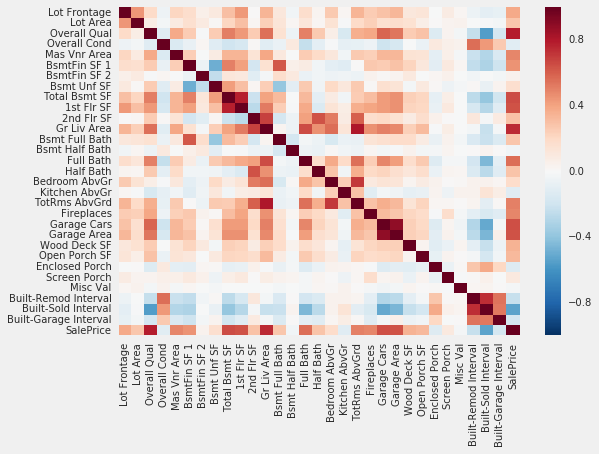

In [93]:
sns.heatmap(transformed_data[num_cols].corr())

### Conclusions
We see that the following columns correlate the most strongly with the _SalePrice_ column:
* _Overall Qual_
* _Gr Liv Area_
* _Total Bsmt SF_
* _Garage Area_ (and the proxy _Garage Cars_)

Moreover, our custom-built feature _Built-Sold Interval_ correlates negatively with _SalePrice_. 

We now look at the actual correlations.

In [76]:
transformed_data[['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF', 'Garage Area', 'Built-Sold Interval']].corr()

,SalePrice,Overall Qual,Gr Liv Area,Total Bsmt SF,Garage Area,Built-Sold Interval
SalePrice,1.000000,0.786946,0.745953,0.649484,0.633384,-0.537552
Overall Qual,0.786946,1.000000,0.554321,0.513991,0.533546,-0.560725
Gr Liv Area,0.745953,0.554321,1.000000,0.399271,0.480866,-0.232747
Total Bsmt SF,0.649484,0.513991,0.399271,1.000000,0.457623,-0.389806
Garage Area,0.633384,0.533546,0.480866,0.457623,1.000000,-0.457597
Built-Sold Interval,-0.537552,-0.560725,-0.232747,-0.389806,-0.457597,1.000000


In [82]:
plt.style.use('fivethirtyeight')
def corr_scatter(col_name):
    plt.scatter(transformed_data['SalePrice'], transformed_data[col_name])
    plt.xlabel('Sale price (dollars)')
    plt.ylabel(col_name)
    plt.show()

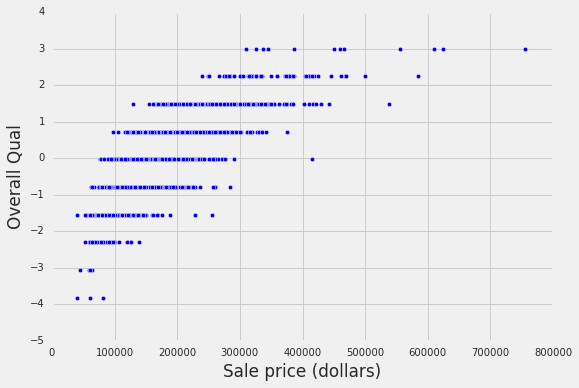

In [83]:
corr_scatter('Overall Qual')

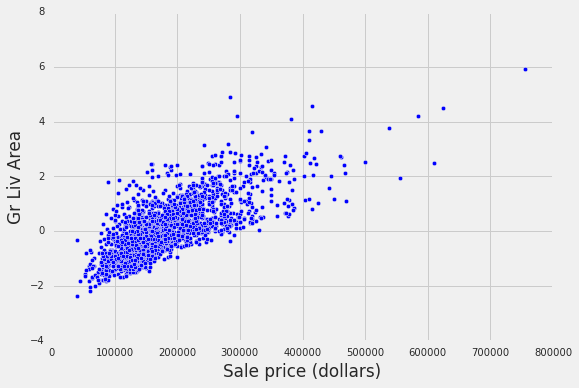

In [84]:
corr_scatter('Gr Liv Area')

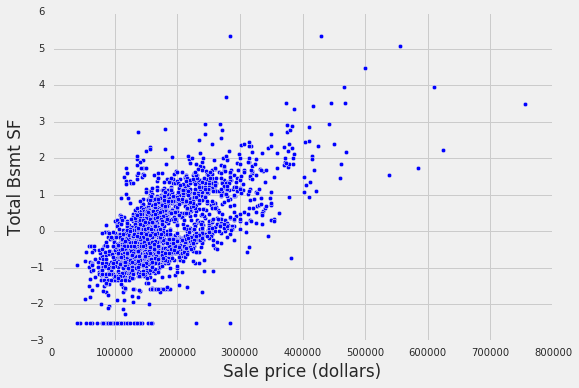

In [85]:
corr_scatter('Total Bsmt SF')

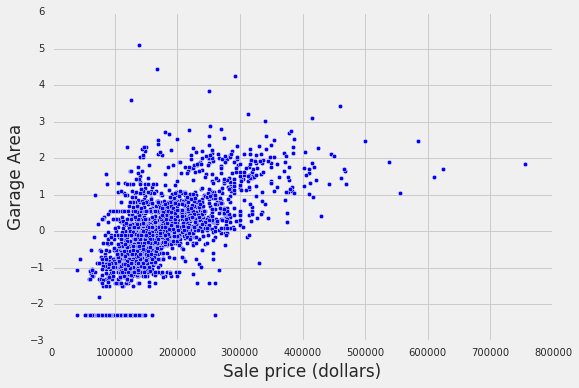

In [86]:
corr_scatter('Garage Area')

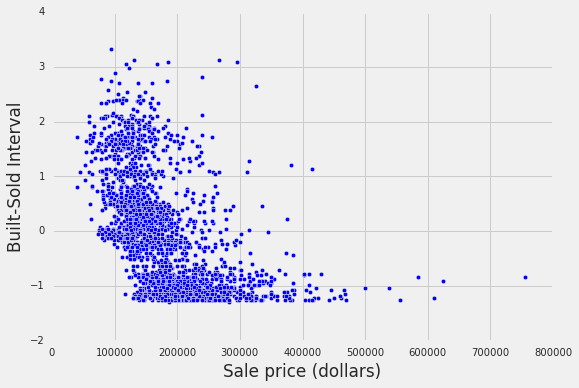

In [87]:
corr_scatter('Built-Sold Interval')

## Feature selection for categorical features

Next we explore which categorical features correlate with the _SalePricee_ column. As a proxy for the features, we use the dummy variables.

In [47]:
def cat_corr(feature_name):
    col_names = [y for y in transformed_data.columns.values if feature_name in y]
    col_names.append('SalePrice')
    sns.heatmap(transformed_data[col_names].corr())
    #print(transformed_data[col_names].corr())

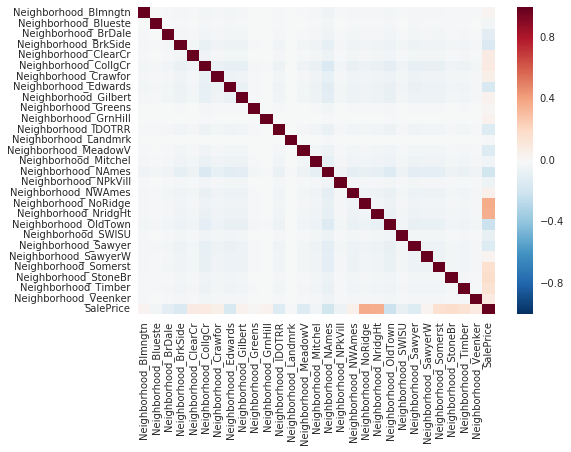

In [96]:
cat_corr(cat_cols[32])

### Conclusions 
By analyzing the correlation heatmap of all the categorical features, we see that no single feature correlates strongly overall with _SalePrice_. We have included the heatmap for the Neighborhood variable to show that, interestingly, there is little correlation between the neighborhood and _SalePrice_.

## Selecting features and training the model

Through our analysis above we have identified a small subset of numerical features that correlate highly with _SalePrice_. As an example, we will train our model with those.

In [84]:
train_and_test(transformed_data, k=10)

30757.129819867918

In [87]:
transformed_data['SalePrice'].describe()

count      2259.000000
mean     176710.882691
std       70631.418343
min       39300.000000
25%      130000.000000
50%      160000.000000
75%      207500.000000
max      755000.000000
Name: SalePrice, dtype: float64

This concludes this simple analysis. We see that the root mean squared error is still quite large compared with the typical values for the _SalePrice_ column, so the model could be 